<h2><center> Logistic Regression</center></h2>

In this section, we do a statistical modelling of the data to predict whether a driver gets warning or citation for the particular violation using logistic regression. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score


In [2]:
# Read the accident data from csv
df_traffic = pd.read_csv('data_wrangled.csv', 
                         index_col = 'Date Of Stop_Time Of Stop',
                         parse_dates = True,
                         infer_datetime_format = True)

df_traffic['V_sage'] = (df_traffic.V_Age - df_traffic.V_Age.min())/\
                  (df_traffic.V_Age.max() - df_traffic.V_Age.min())

not_relevant = ['Latitude', 'Longitude', 'Year', 'Description', 
                'Make', 'Model', 'Color', 'datetime', 'V_Age']
df_traffic.drop(labels = not_relevant, axis = 1,  inplace = True)

In [3]:
# Get X and y from data 
y = df_traffic['Violation Type_Warning']
df_X1 = df_traffic.drop('Violation Type_Warning', axis = 1)
X = df_X1.values

# now,  do a Logistic regression to the data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size = 0.5, 
                                   random_state=77)

At the first step, we begin if we can make a prediction using simple logistic regression. We first optimize the regression using randomized search. The best parameters obtained from randomized search will be used to make the prediction. 

In [4]:
# Setup the hyperparameter grid for a randomized grid search
param_grid = {'C': np.logspace(-5,5,50), 'fit_intercept': [True, False],
             'intercept_scaling': np.arange(0.05, 10, 0.25), 
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] ,
             'random_state': [77]}

# Instantiate a logistic regression classifier: Random Forest
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
model_lr = RandomizedSearchCV(logreg, param_grid, 
                              cv = 5, 
                              n_jobs = -1)

# Fit it to the data
model_lr.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(model_lr.best_params_)) 
print("Best score is {}".format(model_lr.best_score_))


Tuned Logistic Regression Parameters: {'solver': 'newton-cg', 'random_state': 77, 'intercept_scaling': 2.8, 'fit_intercept': True, 'C': 2329.951810515372}
Best score is 0.7593341563073974


[[199183  87981]
 [ 55218 258690]]
             precision    recall  f1-score   support

    Citaton       0.78      0.69      0.74    287164
    Warning       0.75      0.82      0.78    313908

avg / total       0.76      0.76      0.76    601072



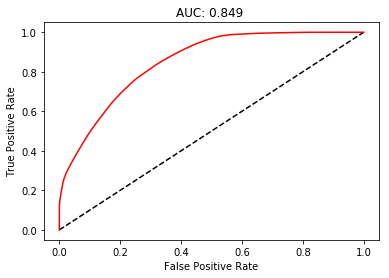

In [5]:
logreg = LogisticRegression(solver = 'newton-cg', n_jobs = -1, intercept_scaling = 0.55,
                            fit_intercept = True, C = 0.3089,
                            multi_class = 'ovr', class_weight =  'balanced',
                            random_state = 77)

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred,  target_names = ['Citaton', 'Warning']))

y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr_lr,tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--', fpr_lr, tpr_lr, 'r')

# Plot ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("AUC: %5.3f "%( roc_auc_score(y_test, y_pred_prob)))

#plt.title('ROC Curve')
plt.show()

G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


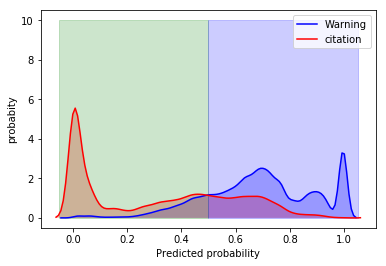

In [6]:
y_pred_prob = logreg.predict_proba(X)[:,1]
ypp = pd.DataFrame(data = y_pred_prob, columns = ['predicted'])
ypp['real'] = y.values

ypp1 = ypp[ypp.real == 1]
ypp0 = ypp[ypp.real == 0]
ax = sns.kdeplot(ypp1.predicted, shade=True, color="b", label = 'Warning')
sns.kdeplot(ypp0.predicted, shade=True, color="r", ax = ax, label = 'citation')

plt.fill_between([-0.05,0.5], 0, 10, color = 'g', alpha = 0.2)
plt.fill_between([0.5,1.05], 0, 10, color = 'b', alpha = 0.2)

plt.xlabel('Predicted probability')
plt.ylabel('probabity')
plt.show()

In [7]:
from joblib import dump, load
dump(logreg, 'Logistic_regression.joblib') 
#logreg2 = load('Logistic_regression.joblib') 

['Logistic_regression.joblib']